## REQUIRED PACKAGGES

In [1]:
# Machine learning packages
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape, Activation, LSTM, TimeDistributed, GlobalMaxPool2D, BatchNormalization, Dropout, InputLayer
from keras.callbacks import EarlyStopping
from keras import backend as k

# Dataset management packages
from spivutils.synthetic_datasets.spid import load_data
from spivutils.batch_generators.keras_generator import batch_data
from spivutils.common_tools.operations import normalization, vectoraddition, thresholding, imagecropping

# General purpose packages
import numpy as np
import json
import gc

2023-11-14 17:46:56.793068: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-14 17:47:06.322976: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## HARDWARE SETTINGS

In [2]:
# Detects the avaiable hardware
cpu_devices = tf.config.list_physical_devices('CPU')
gpu_devices = tf.config.experimental.list_physical_devices('GPU')

# Allow memory growth
for gpu in gpu_devices:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-14 17:47:16.461711: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:47:16.967290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:47:16.967584: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## MODEL HYPERPARAMETERS

In [3]:
# CNN Layers Hyperparameters
cnn_layers = 10
filters = [2, 4, 8, 16, 32, 64, 128] + [128]*10                     #   Layer (+) --> (+)
kernel_size = [3]*15                                                 #   Layer (+) --> (-)
pool_size = [2]*15               #   Layer (+) --> (-)
padding = 'same'
strides = 1
momentum = 0.95

# Dense Layers Hyperparameters
dense_layers = 10                                        # Number of Dense Layers
dense_units = [2048, 1024, 512, 256, 128, 64, 32] + [32]*4    # Hidden units per layer

# LSTM Layers Hyperparameters
lstm_layers = 4                                         # Number of LSTM Layers
lstm_units = [32, 64, 128, 256, 512, 1024]              # Hidden units per layer

# Training Hyperparameters
chunk_size = 1000                                        # Slice of the dataset
batch_size = 5                                      # Number of patterns shown to the network before weight matrix update
epochs = 10                                             # Number of times that the model sees the dataset
activation = 'LeakyReLU', 'linear'                           # Sets the activation functions
optimizer_function = 'adam'                                      # Weight update after each iteration
loss_function = 'mean_squared_error'                             # Sets the Loss function
learning_rate = 0.001                                           
dropout = 0.1



## DATA MANAGING

In [4]:
# Data importing
(train_x, train_y), (valid_x, valid_y), _ = load_data()

# Collect a chunk of the dataset
train_x_chunk = train_x[0:int(chunk_size*0.7)]
train_y_chunk = train_y[0:int(chunk_size*0.7)]
valid_x_chunk = valid_x[0:int(chunk_size*0.15)]
valid_y_chunk = valid_y[0:int(chunk_size*0.15)]

# Load data in batches to avoid memory overload
train_batch = batch_data(train_x_chunk, train_y_chunk, batch_size)
valid_batch = batch_data(valid_x_chunk, valid_y_chunk, batch_size)


 Checking files ...

 train_x.npy  Found!

 train_y.npy  Found!

 valid_x.npy  Found!

 valid_y.npy  Found!

 test_x.npy  Found!

 test_y.npy  Found!

 Importing data ...

 Data loading successful!


## Pre-processing

In [5]:
def standardization(input_data):

    output_data = np.zeros(input_data.shape)

    #min = np.min(input_data)
    #max = np.max(input_data)

    max = 8.75
    min = 0

    output_data[:, :, :] = (input_data[:, :, :] - min)/(max - min)

    return output_data

In [6]:
def standardization(input_data):

    output_data = np.zeros(input_data.shape)

    #min = np.min(input_data)
    #max = np.max(input_data)

    max = 8.75
    min = -8.75

    for i in range(2):

        output_data[:, i, :, :] = (input_data[:, i, :, :] - min)/(max - min)

    return output_data

In [6]:
train_batch.add_x_preprocessing_operation(imagecropping)
valid_batch.add_x_preprocessing_operation(imagecropping)

train_batch.add_y_preprocessing_operation(imagecropping)
valid_batch.add_y_preprocessing_operation(imagecropping)

train_batch.add_y_preprocessing_operation(vectoraddition)
valid_batch.add_y_preprocessing_operation(vectoraddition)

train_batch.add_x_preprocessing_operation(normalization)
valid_batch.add_x_preprocessing_operation(normalization)

train_batch.add_y_preprocessing_operation(standardization)
valid_batch.add_y_preprocessing_operation(standardization)

In [ ]:
# 1 = 7.0427
# vec - off
# norm - off
# std - off

#2 = 5.4538
# vec - on
# norm - off
# std - off

#3 = 7.086706161499023
# vec - off
# norm - on
# std - off

#4 = 0.024497942999005318
# vec - off
# norm - off
# std - on

#5 = 0.024538975208997726
# vec - off
# norm - on
# std - on

#6
# vec - on
# norm - on
# std - on

## Model Definition

In [7]:
# Convolutional neural network setup
def build_cnn_layers(model, num_layers, filters, kernel_size, pool_size, strides, padding, activation, momentum):

    for layer in range(0, num_layers):
        model.add(TimeDistributed(Conv2D(   
                                            filters = filters[layer], 
                                            kernel_size = kernel_size[layer],
                                            strides = strides, 
                                            padding = padding
                                            
                                            )))

        model.add(TimeDistributed(Activation(activation[0])))
        
        model.add(TimeDistributed(BatchNormalization(momentum = momentum)))

        model.add(TimeDistributed(MaxPooling2D(pool_size = pool_size[layer], 
                                               padding = padding)))
       
    model.add(TimeDistributed(Flatten()))

In [8]:
def build_lstm_layers(model, lstm_units, num_layers):

    for layer in range(0, num_layers - 1):

        model.add(LSTM(units = lstm_units[layer], return_sequences = True))

    model.add(LSTM(units = lstm_units[layer], return_sequences = False))

In [9]:
def build_dense_layers(model, dense_units, activation, num_layers, dropout):

    for layer in range(0, num_layers):

        model.add(Dense(units = dense_units[layer]))
        model.add(Activation(activation[0]))
        model.add(Dropout(dropout))  

In [10]:
def build_model(input_shape, output_shape, filters, kernel_size, pool_size, lstm_units, dense_units, activation, padding):

    model = Sequential()

    model.add(InputLayer(input_shape))

    build_cnn_layers(model, cnn_layers, filters, kernel_size, pool_size, strides, padding, activation, momentum)

    build_lstm_layers(model, lstm_units, lstm_layers)

    build_dense_layers(model, dense_units, activation, dense_layers, dropout)

    model.add(Dense(np.prod(output_shape)))
    model.add(Activation(activation[1]))

    model.add(Reshape(output_shape))

    return model

In [11]:
# Model dimensions
input_shape = train_batch[0][0][0,].shape
output_shape = train_batch[0][1][0,].shape

model = build_model(input_shape, output_shape, filters, kernel_size, pool_size, lstm_units, dense_units, activation, padding)

model.compile(loss = loss_function, optimizer = optimizer_function)

2023-11-14 17:47:22.066139: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:47:22.066661: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:47:22.067108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:47:31.420558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-14 17:47:31.421644: I tensorflow/compile

## MODEL SUMMARIZATION

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 2, 630, 630, 2)    20        
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 2, 630, 630, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 2, 630, 630, 2)    8         
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 2, 315, 315, 2)    0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 2, 315, 315, 4)    7

## MODEL TRAINING

In [13]:
# Defines an Early Stop callback
#es_callback = EarlyStopping(monitor = 'val_loss', patience = 3)

class ClearMemory(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        gc.collect()
        k.clear_session()

In [14]:
history = model.fit(train_batch, validation_data = valid_batch, epochs = epochs, callbacks = [ClearMemory()])

2023-11-14 17:47:35.930615: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15876000 exceeds 10% of free system memory.


Epoch 1/10


2023-11-14 17:47:56.986179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-11-14 17:48:25.648045: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1b0c0183d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-14 17:48:25.648101: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1660 Ti, Compute Capability 7.5
2023-11-14 17:48:27.928381: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-14 17:48:35.476835: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  5/140 [>.............................] - ETA: 34s - loss: 0.2710

2023-11-14 17:48:49.724526: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15876000 exceeds 10% of free system memory.


 24/140 [====>.........................] - ETA: 1:06 - loss: 0.2088

2023-11-14 17:49:01.802507: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15876000 exceeds 10% of free system memory.


 28/140 [=====>........................] - ETA: 1:02 - loss: 0.2116

KeyboardInterrupt: 

2023-11-14 17:49:06.943247: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15876000 exceeds 10% of free system memory.


In [ ]:
train_data = '12_11_23'
train_hour = '23_45'
model_name = 'model_2'
train_name =  model_name + '_' + train_data + '_' + train_hour

In [ ]:
# Saves weights and architecture
model.save(train_name + '.keras')

# Saves training history
with open(train_name + '.json', 'w') as file:
    json.dump(history.history, file)

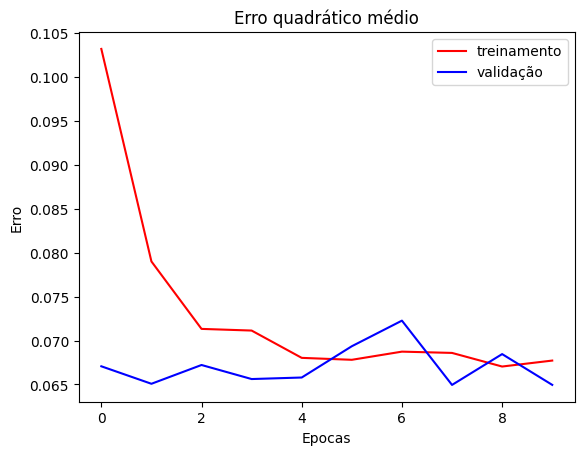

In [ ]:
def plot_loss(history):
    loss = history['loss']
    valloss = history['val_loss']
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'r', label = 'treinamento')
    plt.plot(epochs, valloss, 'b', label = 'validação')
    plt.title('Erro quadrático médio')
    plt.xlabel('Epocas')
    plt.ylabel('Erro')
    plt.legend()

import matplotlib.pyplot as plt

plot_loss(history.history)

np.min(history.history['loss'])

In [ ]:
# 1 = 7.0427
# vec - off
# norm - off
# std - off

#2 = 5.4538
# vec - on
# norm - off
# std - off

#3 = 7.086706161499023
# vec - off
# norm - on
# std - off

#4 = 0.024497942999005318
# vec - off
# norm - off
# std - on

#5 = 0.024538975208997726
# vec - off
# norm - on
# std - on

#6 =
# vec - on
# norm - on
# std - on